In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import numpy as np
import pandas as pd
import tqdm

from datetime import date
from pathlib import Path

from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau

from matplotlib import pyplot as plt
%matplotlib inline

## 1. Прочитайте и проанализируйте данные

выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года; 
в тестовый — турниры с dateStart из 2020 года.


In [3]:
%%time

path = Path('chgk')

with open(path / 'players.pkl', 'rb') as f:
    players_data = pickle.load(f)
    
with open(path / 'results.pkl', 'rb') as f:
    results_data = pickle.load(f)
    
with open(path / 'tournaments.pkl', 'rb') as f:
    tournaments_data = pickle.load(f)

CPU times: user 8.44 s, sys: 1.03 s, total: 9.47 s
Wall time: 9.49 s


In [4]:
players_data

{1: {'id': 1, 'name': 'Алексей', 'patronymic': None, 'surname': 'Абабилов'},
 10: {'id': 10, 'name': 'Игорь', 'patronymic': '', 'surname': 'Абалов'},
 11: {'id': 11,
  'name': 'Наталья',
  'patronymic': 'Юрьевна',
  'surname': 'Абалымова'},
 12: {'id': 12,
  'name': 'Артур',
  'patronymic': 'Евгеньевич',
  'surname': 'Абальян'},
 13: {'id': 13,
  'name': 'Эрик',
  'patronymic': 'Евгеньевич',
  'surname': 'Абальян'},
 14: {'id': 14, 'name': 'Василий', 'patronymic': '', 'surname': 'Абанин'},
 15: {'id': 15,
  'name': 'Олег',
  'patronymic': 'Игоревич',
  'surname': 'Абарников'},
 16: {'id': 16,
  'name': 'Азер',
  'patronymic': 'Абасали оглы',
  'surname': 'Абасалиев'},
 17: {'id': 17, 'name': 'А.', 'patronymic': 'В.', 'surname': 'Абасев'},
 18: {'id': 18, 'name': 'Гияс', 'patronymic': '', 'surname': 'Аббасханов'},
 19: {'id': 19,
  'name': 'Александр',
  'patronymic': 'Миронович',
  'surname': 'Абашев'},
 20: {'id': 20,
  'name': 'Владимир',
  'patronymic': 'Васильевич',
  'surname': 'А

In [5]:
tournaments_data

{1: {'id': 1,
  'name': 'Чемпионат Южного Кавказа',
  'dateStart': '2003-07-25T00:00:00+04:00',
  'dateEnd': '2003-07-27T00:00:00+04:00',
  'type': {'id': 2, 'name': 'Обычный'},
  'season': '/seasons/1',
  'orgcommittee': [],
  'synchData': None,
  'questionQty': None},
 2: {'id': 2,
  'name': 'Летние зори',
  'dateStart': '2003-08-09T00:00:00+04:00',
  'dateEnd': '2003-08-09T00:00:00+04:00',
  'type': {'id': 2, 'name': 'Обычный'},
  'season': '/seasons/1',
  'orgcommittee': [],
  'synchData': None,
  'questionQty': None},
 3: {'id': 3,
  'name': 'Турнир в Ижевске',
  'dateStart': '2003-11-22T00:00:00+03:00',
  'dateEnd': '2003-11-24T00:00:00+03:00',
  'type': {'id': 2, 'name': 'Обычный'},
  'season': '/seasons/2',
  'orgcommittee': [],
  'synchData': None,
  'questionQty': None},
 4: {'id': 4,
  'name': 'Чемпионат Украины. Переходной этап',
  'dateStart': '2003-10-11T00:00:00+04:00',
  'dateEnd': '2003-10-12T00:00:00+04:00',
  'type': {'id': 2, 'name': 'Обычный'},
  'season': '/season

### Проверим, что id в dict совпадают с id внутри каждого элемента, чтобы избежать сюрпризов:

In [6]:
for k,v in players_data.items():
    if k != v['id']:
        print(f'Ключ не равен id для игрока: (k, v)')
        
for k,v in tournaments_data.items():
    if k != v['id']:
        print(f'Ключ не равен id для турнира: (k, v)')

In [7]:
players = pd.DataFrame(players_data.values()).set_index('id', drop=True)
players.head()

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян


### Выделим train и test, и приведем к удобному виду

In [8]:
tournaments = pd.DataFrame(tournaments_data.values()).set_index('id', drop=True)
tournaments['dateStart'] = pd.to_datetime(tournaments['dateStart'], utc=True)
tournaments['dateEnd'] = pd.to_datetime(tournaments['dateEnd'], utc=True)

tournament_types = {}
for t in tournaments['type']:
    tournament_types[t['id']] =  t['name']

tournaments['type'] = tournaments['type'].apply(lambda x: x['id'])

tournaments.drop('orgcommittee', axis=1, inplace=True)
tournaments['year'] = tournaments.dateStart.dt.year
tournaments['month'] = tournaments.dateStart.dt.month
tournaments.head()

,name,dateStart,dateEnd,type,season,synchData,questionQty,year,month
id,,,,,,,,,
1,Чемпионат Южного Кавказа,2003-07-24 20:00:00+00:00,2003-07-26 20:00:00+00:00,2,/seasons/1,None,None,2003,7
2,Летние зори,2003-08-08 20:00:00+00:00,2003-08-08 20:00:00+00:00,2,/seasons/1,None,None,2003,8
3,Турнир в Ижевске,2003-11-21 21:00:00+00:00,2003-11-23 21:00:00+00:00,2,/seasons/2,None,None,2003,11
4,Чемпионат Украины. Переходной этап,2003-10-10 20:00:00+00:00,2003-10-11 20:00:00+00:00,2,/seasons/2,None,None,2003,10
5,Бостонское чаепитие,2003-10-09 20:00:00+00:00,2003-10-12 20:00:00+00:00,2,/seasons/2,None,None,2003,10


### тренировочный набор - турниры с dateStart из 2019 года; тестовый — турниры с dateStart из 2020 года.

In [9]:
tournaments = tournaments[tournaments.year >= 2019]

# Добавим общее количество вопросов
tournaments['total_questions'] = tournaments.questionQty.apply(lambda x: sum((v for k,v in x.items())))
tournaments.head()

,name,dateStart,dateEnd,type,season,synchData,questionQty,year,month,total_questions
id,,,,,,,,,,
4628,Семь сорок,2020-12-30 13:00:00+00:00,2020-12-30 13:00:00+00:00,3,None,{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}",2020,12,36
4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,1,36
4957,Синхрон Биркиркары,2020-02-20 21:00:00+00:00,2020-02-27 20:00:00+00:00,3,/seasons/53,{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,"{'1': 13, '2': 13, '3': 13}",2020,2,39
4973,Балтийский Берег. 3 игра,2019-01-25 16:05:00+00:00,2019-01-29 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,1,36
4974,Балтийский Берег. 4 игра,2019-03-01 16:05:00+00:00,2019-03-05 16:00:00+00:00,3,/seasons/52,{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2019,3,36


In [10]:
train_tournaments = tournaments[tournaments.year == 2019]
test_tournaments = tournaments[tournaments.year == 2020]
print(f'Турниров в train: {len(train_tournaments)}')
print(f'Турниров в test: {len(test_tournaments)}')
print(f'Всего вопросов в train {train_tournaments.total_questions.sum()}')
print(f'Всего вопросов в test {test_tournaments.total_questions.sum()}')

Турниров в train: 689
Турниров в test: 416
Всего вопросов в train 34161
Всего вопросов в test 18135


In [11]:
def get_players_and_questions_qty(results_data, tournaments):
    players = set()
    for idx in tournaments.index:
        for team in results_data[idx]:
            team_id = team['team']['id']
            for player in team['teamMembers']:
                player_id = player['player']['id']
                players.add(player_id)
    return len(players), tournaments.total_questions.sum()

In [12]:
get_players_and_questions_qty(results_data, train_tournaments)

(59394, 34161)

## 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. 
Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


### Соберем список вопросов со сложностью и информацию об ответах игроков

In [13]:
%%time

questions_difficulty = []
players = []

for idx in train_tournaments.index:
    total_questions = train_tournaments.loc[idx].total_questions
    correct = np.zeros(total_questions, dtype=int)
    wrong = np.zeros(total_questions, dtype=int)
    canceled = np.zeros(total_questions, dtype=int)
    team_qty = len(results_data[idx])
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.array([1 if a=='X' else 0 for a in mask])
        mask = np.array([1 if a=='1' else 0 for a in mask])
        if len(mask) > total_questions:
            mask = mask[:total_questions]
        correct[:len(mask)] += mask
        wrong[:len(mask)] += (1 - mask)
        for player in team['teamMembers']:
            player_id = player['player']['id']
            for i, (pos, neg) in enumerate(zip(mask, 1 - mask)):
                if pos == 1:
                    players.append({'player_id': player_id, 'question': f'{idx}_{i}',
                                    'answered': 1, 'not_answered': 0})
                if neg == 1:
                    players.append({'player_id': player_id, 'question': f'{idx}_{i}',
                                    'answered': 0, 'not_answered': 1})
            

    for i, (pos, neg, cnl) in enumerate(zip(correct, wrong, canceled)):
        if np.all(pos == 0) and np.all(neg == 0):
            continue
        questions_difficulty.append({'id': f'{idx}_{i}',
                                     'tournament': idx, 'question': i,
                                     'canceled': cnl,
                                     'positive': pos, 'negative': neg,
                                     'difficulty': 1 - pos/(pos + neg)})
        
questions = pd.DataFrame(questions_difficulty)
questions.head()

CPU times: user 20.2 s, sys: 1.32 s, total: 21.6 s
Wall time: 21.6 s


,id,tournament,question,canceled,positive,negative,difficulty
0,4772_0,4772,0,0,204,27,0.116883
1,4772_1,4772,1,0,180,51,0.220779
2,4772_2,4772,2,0,103,128,0.554113
3,4772_3,4772,3,0,120,111,0.480519
4,4772_4,4772,4,0,203,28,0.121212


In [14]:
player_result = pd.DataFrame(players)
player_result.head()

,player_id,question,answered,not_answered
0,6212,4772_0,1,0
1,6212,4772_1,1,0
2,6212,4772_2,1,0
3,6212,4772_3,1,0
4,6212,4772_4,1,0


In [15]:
# Оставляем только не исключенные вопросы
questions = questions[questions.canceled==0]

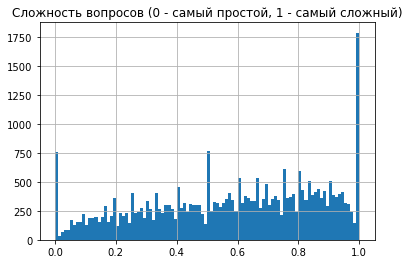

In [16]:
questions.difficulty.hist(bins=100)
plt.title('Сложность вопросов (0 - самый простой, 1 - самый сложный)')
plt.show()

### Посмотрим на распределение турниров по сложности вопросов

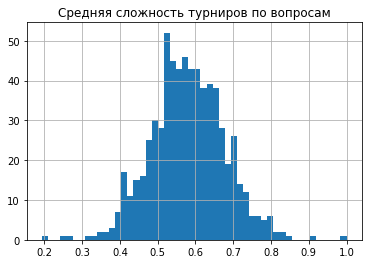

In [17]:
questions.groupby(['tournament']).agg({'difficulty': 'mean'}).hist(bins=50)
plt.title('Средняя сложность турниров по вопросам')
plt.show()

Конечно, это не совсем верно, скорее всего в турнирах со сложными вопросами принимают участие сильные команды. Поэтому нельзя сказать, что если на вопрос ответили мало команд - то он обязательно сложный и наоборот. Но ведь это у нас бейзлайн, так что пусть будет так.

### Разделим вопросы на n_levels уровней сложности и по ним будем строить предсказания рейтинга

In [18]:
n_levels = 5
quantiles = [questions.difficulty.quantile(i/n_levels) for i in range(1, n_levels + 1)]
questions['level'] = 0
for i in range(n_levels, 0, -1):
    questions.loc[questions.difficulty <= quantiles[i - 1], 'level'] = i

Для каждого игрока признаками будет:
- количество вопросов каждой сложности, на которые он ответил правильно
- количество вопросов каждой сложности, на котороые он не ответил правильно

In [19]:
player_result = pd.merge(player_result, questions, how='left', left_on='question', right_on='id')
player_result.head()

,player_id,question_x,answered,not_answered,id,tournament,question_y,canceled,positive,negative,difficulty,level
0,6212,4772_0,1,0,4772_0,4772.0,0.0,0.0,204.0,27.0,0.116883,1.0
1,6212,4772_1,1,0,4772_1,4772.0,1.0,0.0,180.0,51.0,0.220779,1.0
2,6212,4772_2,1,0,4772_2,4772.0,2.0,0.0,103.0,128.0,0.554113,3.0
3,6212,4772_3,1,0,4772_3,4772.0,3.0,0.0,120.0,111.0,0.480519,2.0
4,6212,4772_4,1,0,4772_4,4772.0,4.0,0.0,203.0,28.0,0.121212,1.0


In [20]:
player_result_grouped = player_result.groupby(['player_id', 'level']).agg({'answered': 'sum', 'not_answered': 'sum'})
player_result_grouped['p'] = player_result_grouped['answered'] / (player_result_grouped['answered'] + player_result_grouped['not_answered'])
player_result_grouped['n'] = player_result_grouped['answered'] + player_result_grouped['not_answered']
player_result_grouped = player_result_grouped[['n', 'p']].unstack(-1)
player_result_grouped

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
...          ...    ...    ...    ...    ...       ...       ...       ...   
224404      18.0   24.0   22.0   21.0   11.0  0.388889  0.416667  0.272727   
224408       2.0   10.0    8.0    4.0   12.0  0.500000  0.300000  0.000000   
224482       2.0   11.0    9.0   10.0    4.0  0.500000  0.181818  0.111111   
224539       6.0    8.0    9.0   11.0   11.0  0.666667  0.500000  0.333333   
224542      15.0    8.0    8.0    3.0    2.0  1.000000  0.875000  0.625000   

                               
level           4.0       5.0  
player_id                      
15         0.163793  0.054545  
16         0.189189  0.000000  
23         0.200000  0.000000  
31         0.270270  0.038760  
35         0.242857  0.103448  
...             ...       ...  
224404     0.238095  0.000000  
224408     0.000000  0.000000  
224482     0.000000  0.000000  
224539     0.090909  0.000000  
224542     0.000000  0.000000  

[59271 rows x 10 columns]

Заполним пробелы в данных:

- Nan - заполним медианами в p и 0 в n
- 0.0 в вероятностях правильного ответа, где количество вопросов было меньше 5. Для вопросов со сложностью меньше 5 заменим на медиану или на вероятность для более низкой сложности - смотря что ниже.
- 0.0 во всех остальных случаях заменим на маленькую вероятность.

In [21]:
player_result_grouped['n'] = player_result_grouped['n'].fillna(0)
player_result_grouped['p'] = player_result_grouped['p'].fillna(player_result_grouped['p'].median())

In [22]:
median_p = {}
for i in range(1, n_levels + 1):
    median_p[i] = player_result_grouped.loc[:, ('p', i)].median()
    print(f"Median for difficulty {i}: {median_p[i]}")

Median for difficulty 1: 0.7857142857142857
Median for difficulty 2: 0.4876218776116631
Median for difficulty 3: 0.2777777777777778
Median for difficulty 4: 0.1276595744680851
Median for difficulty 5: 0.0


In [23]:
dfclty = 1
player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & (player_result_grouped[('n', dfclty)] < 5),
                          ('p', dfclty)] = player_result_grouped.loc[:, ('p', dfclty)].median()

In [24]:
for dfclty in range(2, n_levels):
# Тут будем менять на вероятность более нижней сложности
    low_difficulty = player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                                               (player_result_grouped[('n', dfclty)] < 5),
                                               ('p', dfclty - 1)] < median_p[dfclty]
    low_difficulty = low_difficulty[low_difficulty]
    player_result_grouped.loc[low_difficulty.index,
                              ('p', dfclty)] = player_result_grouped.loc[low_difficulty.index,
                                                                             ('p', dfclty - 1)]
# Тут будем менять на среднюю
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                              (player_result_grouped[('n', dfclty)] < 5),
                              ('p', dfclty)] = median_p[dfclty]

Тем кто отвечал на более чем 5 вопросов в категории сложности и получил 0 - будем выставлять минимальную ненулевую вероятность по этой группе вопросов

In [25]:
min_p = {}
for i in range(1, n_levels + 1):
    min_p[i] = player_result_grouped.loc[player_result_grouped[('p', i)] > 0, ('p', i)].min()
    print(f"Min for difficulty {i}: {min_p[i]}")

Min for difficulty 1: 0.043478260869565216
Min for difficulty 2: 0.018518518518518517
Min for difficulty 3: 0.011363636363636364
Min for difficulty 4: 0.0058823529411764705
Min for difficulty 5: 0.003389830508474576


In [26]:
for dfclty in range(1, n_levels):
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0),
                              ('p', dfclty)] = min_p[dfclty]

In [27]:
player_result_grouped['total_questions'] = player_result_grouped['n'].sum(axis=1)
player_result_grouped.head().append(player_result_grouped.tail())

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
224404      18.0   24.0   22.0   21.0   11.0  0.388889  0.416667  0.272727   
224408       2.0   10.0    8.0    4.0   12.0  0.500000  0.300000  0.011364   
224482       2.0   11.0    9.0   10.0    4.0  0.500000  0.181818  0.111111   
224539       6.0    8.0    9.0   11.0   11.0  0.666667  0.500000  0.333333   
224542      15.0    8.0    8.0    3.0    2.0  1.000000  0.875000  0.625000   

                              total_questions  
level           4.0       5.0                  
player_id                                      
15         0.163793  0.054545           560.0  
16         0.189189  0.000000           234.0  
23         0.200000  0.000000            36.0  
31         0.270270  0.038760           865.0  
35         0.242857  0.103448           779.0  
224404     0.238095  0.000000            96.0  
224408     0.127660  0.000000            36.0  
224482     0.005882  0.000000            36.0  
224539     0.090909  0.000000            45.0  
224542     0.127660  0.000000            36.0

### У нас готовы признаки игроков, добавим к ним сложность вопросов и обучим логистическую регрессию

In [28]:
dataset = player_result.drop(['id', 'tournament', 'question_x', 'not_answered',
                              'question_y', 'canceled', 'positive', 'negative', 'level'], axis=1)

In [29]:
print(dataset.memory_usage().sum())
dataset.index = dataset.player_id
dataset.drop('player_id', axis=1, inplace = True)
dataset.dropna(inplace=True)
dataset.head()

675571008


,answered,difficulty
player_id,,
6212,1,0.116883
6212,1,0.220779
6212,1,0.554113
6212,1,0.480519
6212,1,0.121212


In [30]:
dataset = dataset.merge(player_result_grouped.drop('total_questions', axis=1), how='left', left_index=True, right_index=True)
dataset.head()

/home/mikhail/miniconda3/envs/made_cv/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,answered,difficulty,"(n, 1.0)","(n, 2.0)","(n, 3.0)","(n, 4.0)","(n, 5.0)","(p, 1.0)","(p, 2.0)","(p, 3.0)","(p, 4.0)","(p, 5.0)"
player_id,,,,,,,,,,,,
15,1,0.438169,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.196689,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.226874,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.460565,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.703019,100.0,141.0,148.0,116.0,55.0,0.71,0.468085,0.290541,0.163793,0.054545


Проведем нормировку количественных признаков

In [31]:
min_qty = []
max_qty = []
for i in range(1, n_levels + 1):
    min_qty.append(dataset[('n', i)].min())
    max_qty.append(dataset[('n', i)].max())
    dataset[('n', i)] = (dataset[('n', i)] - min_qty[-1]) / (max_qty[-1] - min_qty[-1])

In [32]:
dataset.head()

,answered,difficulty,"(n, 1.0)","(n, 2.0)","(n, 3.0)","(n, 4.0)","(n, 5.0)","(p, 1.0)","(p, 2.0)","(p, 3.0)","(p, 4.0)","(p, 5.0)"
player_id,,,,,,,,,,,,
15,1,0.438169,0.064061,0.067593,0.076014,0.063423,0.040801,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.196689,0.064061,0.067593,0.076014,0.063423,0.040801,0.71,0.468085,0.290541,0.163793,0.054545
15,1,0.226874,0.064061,0.067593,0.076014,0.063423,0.040801,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.460565,0.064061,0.067593,0.076014,0.063423,0.040801,0.71,0.468085,0.290541,0.163793,0.054545
15,0,0.703019,0.064061,0.067593,0.076014,0.063423,0.040801,0.71,0.468085,0.290541,0.163793,0.054545


### Обучим логистическую регрессию

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
dataset_sample = dataset.sample(5000000)
X = dataset_sample.drop('answered', axis=1).values
y = dataset_sample['answered'].values
print(X.shape)

(5000000, 11)


In [35]:
model = LogisticRegression(verbose=1)
model.fit(X, y)
pred = model.predict(X)
print(f'Accuracy: {np.sum(pred == y)/len(pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.7586822


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s finished


### Для каждого игрока теперь просэмплируем по 20000 вопросов разной сложности и посчитаем для каждого игрока на сколько из них он бы ответил - далее построим рейтинг

In [36]:
players_total_questions = player_result_grouped.total_questions.copy()
player_result_grouped.drop('total_questions', axis=1, inplace=True)
players_total_questions.head()

player_id
15    560.0
16    234.0
23     36.0
31    865.0
35    779.0
Name: total_questions, dtype: float64

In [37]:
# Из этого распределения будем сэмплировать вопросы:
p_questions = questions.difficulty

sample_size = 20000
q_sample = np.array(p_questions.sample(sample_size)).reshape(-1, 1)

In [38]:
# Проведем нормировку для количества вопросов
for i in range(1, n_levels + 1):
    player_result_grouped[('n', i)] = (player_result_grouped[('n', i)] - min_qty[-1]) / (max_qty[-1] - min_qty[-1])

In [39]:
players_rating = []
for idx in tqdm.tqdm(player_result_grouped.index):
    player_sample = np.array(player_result_grouped.loc[idx]).reshape(1, -1)
    X = np.hstack([q_sample, np.tile(player_sample, (sample_size, 1))])
    rating = model.predict(X).sum()
    players_rating.append({'id': idx, 'rating': rating})

100%|██████████| 59271/59271 [00:41<00:00, 1436.46it/s]


In [40]:
players_rating = pd.DataFrame(players_rating).sort_values('rating', ascending=False)

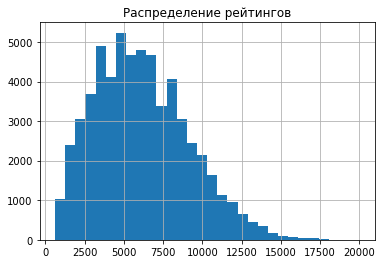

In [41]:
players_rating.rating.hist(bins=30)
plt.title('Распределение рейтингов')
plt.show()

### Распределение рейтингов выглядит неплохо, посмотрим теперь на топ игроков

In [42]:
players_names = pd.DataFrame([v for k, v in players_data.items()])
players_names.index = players_names.id
players_names.drop('id', axis=1, inplace=True)
players_names.head()

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян


In [43]:
players_rating.index = players_rating.id
players_rating.drop('id', axis=1, inplace=True)
players_rating.head()

,rating
id,
36844,20000
216863,18892
170977,18891
171845,18891
180055,18011


In [44]:
players_rating = pd.merge(players_rating, players_names, how='left', left_index=True, right_index=True)
players_rating = pd.merge(players_rating, players_total_questions, how='left', left_index=True, right_index=True)

### Посмотрим на топ-10 игроков, ответивших на более чем 1000 вопросов

In [45]:
linear_rating = players_rating[players_rating.total_questions > 1000]
linear_rating.head(10)

,rating,name,patronymic,surname,total_questions
id,,,,,
27403,17111,Максим,Михайлович,Руссо,2331.0
4270,16939,Александра,Владимировна,Брутер,2881.0
28751,16935,Иван,Николаевич,Семушин,3963.0
27822,16633,Михаил,Владимирович,Савченков,3449.0
30152,16461,Артём,Сергеевич,Сорожкин,5083.0
30270,16316,Сергей,Леонидович,Спешков,3962.0
87637,15976,Антон,Владимирович,Саксонов,1266.0
56647,15516,Наталья,Евгеньевна,Горелова,2165.0
20691,15514,Станислав,Григорьевич,Мереминский,1656.0


Почти все эти игроки находятся очень высоко в рейтинге на сайте https://rating.chgk.info

## 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. 

Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. 
Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

<font color='blue'>Для каждой пары (игрок, вопрос) будем вычислять значение логистической регрессии. Затем для каждой команды усредняем эти значения и получаем "мягкий результат команды по вопросу". Сумма таких результатов за весь турнир - это итоговый результат команды, который определяет ее позицию.</font> <font color='red'> Потом я пересмотрю этот расчет, но решил оставить и этот вариант, чтобы был виден процесс поиска решения </font>

In [46]:
test_tournaments.head()

,name,dateStart,dateEnd,type,season,synchData,questionQty,year,month,total_questions
id,,,,,,,,,,
4628,Семь сорок,2020-12-30 13:00:00+00:00,2020-12-30 13:00:00+00:00,3,None,{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}",2020,12,36
4957,Синхрон Биркиркары,2020-02-20 21:00:00+00:00,2020-02-27 20:00:00+00:00,3,/seasons/53,{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,"{'1': 13, '2': 13, '3': 13}",2020,2,39
5151,Яровой,2020-08-01 11:00:00+00:00,2020-08-05 11:00:00+00:00,3,/seasons/53,{'dateRequestsAllowedTo': '2020-07-24T23:59:59...,"{'1': 12, '2': 12, '3': 12}",2020,8,36
5414,Синхрон северных стран,2020-01-03 16:00:00+00:00,2020-01-10 16:00:00+00:00,3,/seasons/53,{'dateRequestsAllowedTo': '2020-01-10T23:59:00...,"{'1': 12, '2': 12, '3': 12}",2020,1,36
5477,Онлайн: Синхрон Урюбджирова,2020-04-18 16:00:00+00:00,2020-04-30 16:00:00+00:00,8,/seasons/53,{'dateRequestsAllowedTo': '2020-04-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}",2020,4,36


In [47]:
class Tournament():
    def __init__(self, idx, results=results_data,
                 tournaments=test_tournaments,
                 model=model, p_questions=p_questions, 
                 players_features=player_result_grouped):
        self.idx = idx
        self.results = results[idx]
        self.model = model
        self.players_features = players_features
        
        self.total_questions = tournaments.loc[idx, 'total_questions']
        self.teams = self._load_teams()
        self.questions = np.array(p_questions.sample(self.total_questions)).reshape(-1, 1)
        
    def _load_teams(self):
        teams = []
        for team in self.results:
            if 'position' not in team or team['mask'] is None:
                continue
            current_team = {}
            current_team['name'] = team['team']['name']
            current_team['position'] = team['position']
            current_team['members'] = self._load_team_members(team)
            teams.append(current_team)
        return teams
        
    def _load_team_members(self, team):
        players = {}
        for player in team['teamMembers']:
            player_id = player['player']['id']
            if player_id not in player_result_grouped.index:
                continue
            player_features = np.array(player_result_grouped.loc[player_id]).reshape(1, -1)
            players[player_id] = player_features
        return players
        
    def simulate(self):
        if len(self.teams) == 0:
            return None, None
        predicted_results = []
        factual_results = []
        for team in self.teams:
            prediction = self._simulate_team_result(team)
            if prediction == 0:
                continue
            factual_results.append(team['position'])
            predicted_results.append(prediction)
        return predicted_results, factual_results
    
    def _simulate_team_result(self, team):
        team_size = len(team['members'])
        if team_size == 0:
            return 0
        team_features = np.vstack([v for k, v in team['members'].items()])
        result = 0
        for q in self.questions:
            full = np.hstack([np.tile(q, (team_size, 1)), team_features])
            probs = model.predict_proba(full)[:,1]
            result += np.mean(probs)
        return -result
    
tmp_tournament = Tournament(5477)
prediction, ground_true = tmp_tournament.simulate()

In [48]:
spearman_correlations = []
kendall_correlations = []
for idx in tqdm.tqdm(test_tournaments.index):
    if results_data[idx]:
        tournament = Tournament(idx)
        prediction, ground_true = tournament.simulate()
        if prediction is None or ground_true is None:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)

100%|██████████| 416/416 [01:20<00:00,  5.19it/s]


In [49]:
print(f'Корреляция Спирмена: {np.mean([t for t in spearman_correlations if np.isfinite(t)]):0.2f}')
print(f'Корреляция Кендалла: {np.mean([t for t in kendall_correlations if np.isfinite(t)]):0.2f}')

Корреляция Спирмена: 0.71
Корреляция Кендалла: 0.55


### Значения корреляций Спирмена и Кендалла находятся в пределах того, чтобы было описано в задании

## 4. Теперь главное: ЧГК — это всё-таки командная игра. 
Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


In [50]:
total_players, total_questions = get_players_and_questions_qty(results_data, train_tournaments)
print(f'В train всего {total_players} игроков')
print(f'В train всего {total_questions} вопросов')

В train всего 59394 игроков
В train всего 34161 вопросов


### Идеи и допущения:
    
    в Train у нас 59394 игроков и 34161, ранее мне не хотелось работать с матрицей размера 34161x59394 и я решил попробовать вручную сделать feature extraction. Далее придется все-таки перейти к работе с такой матрицей, вот почему:

Модель для ответов на вопрос каждого игрока

- Ранее я собирал для каждого игрока несколько features исходя из его ответов на вопросы разной сложности. Теперь оставлю ровно 1 feature для каждого игрока - это и будет его скилл - $p_{i}$. Каждый вопрос будет характеризоваться сложностью $q_{j}$.

- Ответил игрок i на вопрос j - это по сути бинарная классификация, используем как и в бейзлайне логистическую регрессию, но теперь без дополнительных признаков - на вход подаем 2 конкатенированных one_hot вектора - номер игрока и номер вопроса (59394 + 34161), на выходе 1 или 0. Заметим, что в такой постановке, когда на вход подается вектор из 0 и 1 - мы в качестве аргумента сигмоиды будем получать $p_{i} + q_{j} + const$.

Применение EM алгоритма

- Мы не можем зафиксировать команды, так как игрок может произвольно менять команду от турнира к турниру, поэтому далее объект "команда" - это вектор из 0 и 1 размера 59394, в котором 1 означает, что игрок входит в команду, а 0 - не входит.

- Мы наблюдаем ответ команды в целом на вопрос, пусть $x_{ti} = 1$ означает что команда $t$ ответила на вопрос $q$, и $x_{ti} = 0$ означает что команда $t$ не ответила на вопрос $i$

- Как показали ранее мы моделируем ответ игрока $i$ на вопрос $j$ как $\sigma(p_{i} + q_{j} + const)$

- Обозначим скрытые переменные $z_{ij}$ - ответ игрока $i$ на вопрос $j$ - мы не знаем как отвечал конкретный игрок внутри команды, но можем попробовать связать их $z_{ij}$ с $x_{tj}$ - ответом команды на копрос $j$:


1. Если команда $t$ не ответила на вопрос $i$, то считаем, что ни один из игроков не ответил на вопрос (случай, когда кто-то знал правильный ответ, но команда выбрала другой ответ - не рассматриваем), т.е. $z_{ij} = 0 \forall j \in t$
2. Если команда $t$ ответила на вопрос $i$, то считаем, что как существует как минимум 1 игрок из этой команды, который знал правильный ответ: $\exists j \in t: z_{ij} = 1$

### Собственно EM алгоритм:

- нулевой шаг: Обучим логистические регрессии  $x_{tj} \sim \sigma(p_{i} + q_{j} + const) \forall i \in t$ и найдем начальные значения $p_{i}$ и $q_{j}$ - заодно проверим насколько такие решения отличаются от бейзлайна, возможно это и стоило считать бейзлайном :-)

- E-шаг - найдем мат. ожидания $z_{i}{j}$:
$\mathbf{E}z_{ij} = 
\begin{cases}
0, \forall i \in t, \text{если команда t не ответила на вопрос j}\\
\frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \in t}(1 - \sigma(p_{k} + q_{j} + const))}, \text{если команда t ответила на вопрос j - далее покажу как пришел к этому}\\
\end{cases}$

- M-шаг - с новыми $\mathbf{E}z_{ij}$ обновляем $p_{i}$ и $q_{j}$, то есть находим оптимальные значения для задачи: $\mathbf{E}z_{ij} \sim \sigma(p_{i} + q_{j} + const)$

### Вывод E-шага:

Если команда ответила на вопрос правильно, то хотя бы один игрок смог ответить правильно.
Пусть у нас в команде $m$ игроков и событие, что они дали правильный ответ на текущий вопрос с текущими $p_{i}$ и $q_{j}$ - $A_{i} \forall i \leqslant m$

$p(A_{i}) = \sigma(p_{i} + q_{j} + const) \forall i \leqslant m$

Событие $B$ - это команда ответила правильно, вероятность этого события $P(B) = 1 - \prod_{i \leqslant m}(1 - p(A_i))$ - то есть вероятность того, что хотя бы один из игроков дал правильный ответ.

В E-шаге нам нужно вычислить $\mathbf{E}(z_{ij})$ то есть мат ожидание вероятности того, что игрок ответил правильно, при условии, что команда ответила правильно, то есть: $P(z_{ij}|x_{tj})$

Применим теорему Байеса:

$P(z_{ij}|x_{tj}=1) = P(A_i|B) = \frac{P(B|A_i)P(A_i)}{P(B)} = $ 

учтем, что вероятность $P(B|A_i)=1$ т.к. если игрок дал правильный ответ, то и команда дала правильный ответ

$= \frac{P(A_i)}{P(B)} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - p(A_k))} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - \sigma(p_{k} + q_{j} + const))}$

### 0-й шаг - baseline #2

#### Соберем id всех игроков и всех вопросов в результатах турниров за 2019 год

In [51]:
player_ids = set()
train_questions_qty = 0

for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
        for player in team['teamMembers']:
            player_ids.add(player['player']['id'])

    train_questions_qty += (tournament_questions - canceled)
    
player_ids = np.array(list(player_ids)).reshape(-1, 1)
print(f'Всего игроков: {(player_ids.shape[0])}')
print(f'Всего вопросов: {train_questions_qty} - исключили вопросы, которые были отменены/сняты')

100%|██████████| 689/689 [00:01<00:00, 649.77it/s]

Всего игроков: 59271
Всего вопросов: 34078 - исключили вопросы, которые были отменены/сняты


In [52]:
total_players = player_ids.shape[0]
total_questions = train_questions_qty

In [53]:
from scipy.sparse import vstack, hstack
from sklearn.preprocessing import OneHotEncoder

In [54]:
ohe_players = OneHotEncoder()
ohe_players.fit(player_ids)

ohe_questions = OneHotEncoder()
ohe_questions.fit(np.arange(train_questions_qty).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

### Соберем матрицу ответов игроков на вопросы и target

In [55]:
target = []
data = []
total_pairs = 0

tournament_first_question_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    if len(results_data[idx]) == 0:
        continue
    tournament_questions = train_tournaments.loc[idx].total_questions
    team_data = []
    for team in results_data[idx]:
        # Если по команде нет результата - то пропускаем
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        
        # Убираем снятые вопросы (отмеченные 'Х')
        mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])
        
        team_size = len(team['teamMembers'])
        questions_qty = mask.shape[0]
        
        # Если в команде нет игроков - пропускаем
        if team_size == 0:
            continue
            
        # Левая часть матрицы - one_hot_vector игроки
        players = np.array([np.full((questions_qty, ), player['player']['id'])
                                for player in team['teamMembers']]).reshape(-1, 1)
        players_matrix = ohe_players.transform(players)
        
        # Правая часть матрицы - one_hot_vector вопросы
        questions_list = np.tile(
            np.arange(tournament_first_question_idx,
                      tournament_first_question_idx + questions_qty
                     ),
            team_size
        ).reshape(-1, 1)
        questions_matrix = ohe_questions.transform(questions_list)
        
        # Результаты ответов
        target.extend(np.tile(mask, team_size))
        
        team_data.append(hstack([players_matrix,
                                 questions_matrix]))
    tournament_first_question_idx += questions_qty
    if len(team_data) > 0:
        data.append(vstack(team_data))

X = vstack(data)
y = np.array(target)

100%|██████████| 689/689 [01:51<00:00,  6.16it/s]


### Обучим модель

In [56]:
%%time

baseline_2 = LogisticRegression(verbose=1, solver='saga')
baseline_2.fit(X, y)
pred = baseline_2.predict(X)
print(f'Accuracy: {np.sum(pred == y)/len(pred)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 252 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished


Accuracy: 0.7555404137273181
CPU times: user 4min 13s, sys: 1.67 s, total: 4min 15s
Wall time: 4min 16s


### Посчитаем правдоподобие

In [94]:
def log_loss(pred, target, weights=None):
    if weights is not None:
        return np.average(-target * np.log(pred) - (1 - target) * np.log(1 - pred), weights=weights)
    return np.mean(-target * np.log(pred) - (1 - target) * np.log(1 - pred))

In [95]:
proba = baseline_2.predict_proba(X)[:, 1]
print(f'Log loss: {log_loss(proba, y):0.4f}')

Log loss: 0.4918


### Оценим качество

In [96]:
p = baseline_2.coef_[0][:total_players]
q = baseline_2.coef_[0][total_players:]

Посмотрим на распределение сложности вопросов:

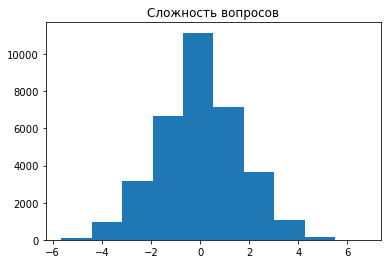

Средняя сложность вопроса: -5.5966151025765765e-05


In [97]:
plt.hist(q)
plt.title('Сложность вопросов')
plt.show()
print(f'Средняя сложность вопроса: {np.mean(q)}')

<font color='red'> Вот тут я пересмотрел способ расчета рейтинга </font> 
В такой модели сложность вопросов получила совсем другое распределение с явным пиком в 0. Идея в следующем - давайте посчитаем вероятность того, что команда ответит правильно на "средний вопрос":

$P(A) = 1 - \prod_{i \in t}(1 - \sigma(p_i + const)$

Я попробовал 2 подхода к учету игроков, которые играли в 2020 году, но не играли в 2019:
- Заменять их на копию "самого слабого игрока в команде"
- Пропускать их совсем

Вариант с пропуском привел к чуть более высоким метрикам на test, поэтому его и используем.

"Средний" вопрос имеет сложность 0, найдем подобный вопрос из датасета:

In [98]:
average_q = np.argmin(np.abs(q))
average_question = ohe_questions.transform([[average_q]])
print(f'Сложность вопроса {average_q}: {q[average_q]}, его и будем считать средним для удобства')

Сложность вопроса 12367: 0.0, его и будем считать средним для удобства


In [99]:
def calculate_metrics(model, tournaments=test_tournaments, result=results_data,
                        ohe_players=ohe_players,
                        ohe_questions=ohe_questions,
                        average_q=average_q):
    spearman_correlations = []
    kendall_correlations = []
    for i, idx in enumerate(tqdm.tqdm(tournaments.index)):
        prediction, ground_true = [], []
        for team in result[idx]:
            # Если по команде нет результата - то пропускаем
            if 'position' not in team:
                continue
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue
    
            team_size = len(team['teamMembers'])
            # Если в команде нет игроков - пропускаем
            if team_size == 0:
                continue
            team_members = []
            for player in team['teamMembers']:
                # Пропускаем новых игроков, которых не было в train
                try:
                    ohe_players.transform([[player['player']['id']]])
                    team_members.append(player['player']['id'])
                except ValueError:
                    continue
            team_size = len(team_members)
            if team_size == 0:
                continue
                
            ground_true.append(team['position'])
            players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
            question_matrix = ohe_questions.transform(np.full((team_size, 1), average_q))
            X = hstack([players_matrix, question_matrix])
            skill = model.predict_proba(X)[:, 1]
            team_rating = 1 - np.prod(1 - skill)
            prediction.append(-team_rating)
        if np.unique(ground_true).shape[0] == 1:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)
            
    spearman_corr = np.mean([t for t in spearman_correlations if np.isfinite(t)])
    kendall_corr = np.mean([t for t in kendall_correlations if np.isfinite(t)])
    return spearman_corr, kendall_corr

In [100]:
spearman_baseline_2, kendall_base_line_2 = calculate_metrics(baseline_2)
print(f'Корреляция Спирмена: {spearman_baseline_2:0.2f}')
print(f'Корреляция Кендалла: {kendall_base_line_2:0.2f}')

100%|██████████| 416/416 [01:20<00:00,  5.14it/s]

Корреляция Спирмена: 0.79
Корреляция Кендалла: 0.64


#### В этом варианте baseline метрики существенно лучше, чем в первой версии


### E-шаг

In [101]:
from scipy.sparse import csc_matrix

def E_step(model, train_data=X,
           y = y,
           tournaments=train_tournaments,
           result=results_data,
           num_players=total_players,
           num_questions=total_questions):
    
    predictions = model.predict_proba(train_data)[:, 1]
    z = np.zeros(predictions.shape)   
    tournament_first_question_idx = 0
    current_idx = 0
    
    for idx in tqdm.tqdm(tournaments.index):
        if len(result[idx]) == 0:
            continue
        tournament_questions = tournaments.loc[idx].total_questions
        team_data = []
        for team in result[idx]:
            # Если по команде нет результата - то пропускаем
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue

            # Убираем снятые вопросы (отмеченные 'Х')
            mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])

            team_size = len(team['teamMembers'])
            questions_qty = mask.shape[0]
            batch_size = team_size * questions_qty

            # Если в команде нет игроков - пропускаем
            if team_size == 0:
                continue

            # Ответы команды
            team_answers = predictions[current_idx: current_idx + batch_size]
            true_team_answers = y[current_idx: current_idx + questions_qty]
            
            # Приведем к виду матрицы где в каждой строке - ответы всей команды на вопрос
            
            team_answers = team_answers.reshape((-1, questions_qty)).T
            
            # Вычислим z по формуле из E-шага
            denominator = 1 - np.prod(1 - team_answers, axis=1)
            team_answers = team_answers / denominator.reshape(-1, 1)
            
            team_answers[true_team_answers==0, :] = 0
            
            predictions[current_idx: current_idx + batch_size] = team_answers.T.reshape(-1) 
            current_idx += batch_size
    return predictions

### M-шаг

Теперь нам нужно обучить параметры p, q, проблема в том, что у нас target (z) для логистической регрессии равен z и это вещественные числа от 0 до 1, а не метки классов.

Попробую следующий метод - для каждого z в обучающую выборку поместим по 2 строки с таргетами 0 и 1 и обучать будем с весами (1-z) и z соответственно.

In [103]:
def M_step(z, train_data=X):
    y_0 = np.zeros((train_data.shape[0], 1))
    y_1 = np.ones((train_data.shape[0], 1))
    y = np.vstack([y_0, y_1]).reshape(-1)
    train_data = vstack([train_data, train_data])
    weights = np.concatenate([1 - z, z])
    model = LogisticRegression(verbose=1, solver='saga')
    model.fit(train_data, y, sample_weight=weights)
    proba = model.predict_proba(train_data)[:, 1]
    return model, log_loss(proba, y, weights)

In [104]:
spearman_train, kendall_train = calculate_metrics(baseline_2, tournaments=train_tournaments)
spearman_test, kendall_test = calculate_metrics(baseline_2)
print('Baseline #2')
print(f'Корреляция Спирмена - train: {spearman_train:0.4f}')
print(f'Корреляция Кендалла - train: {kendall_train:0.4f}')
print(f'Корреляция Спирмена - test: {spearman_test:0.4f}')
print(f'Корреляция Кендалла - test: {kendall_test:0.4f}')

100%|██████████| 416/416 [01:20<00:00,  5.15it/s]

Baseline #2
Корреляция Спирмена - train: 0.8333
Корреляция Кендалла - train: 0.6828
Корреляция Спирмена - test: 0.7938
Корреляция Кендалла - test: 0.6359


#### Проведем несколько итераций EM алгоритма и посмотрим на метрики на train и test

In [105]:
import time

spearman_train = [spearman_train]
spearman_test = [spearman_test]
kendall_train = [kendall_train]
kendall_test = [kendall_test]

best_metrics = np.mean([spearman_test, kendall_test])
best_em_model = baseline_2

model_m = baseline_2
for i in range(5):
    time.sleep(0.5)
    
    z = E_step(model=model_m)
    model_m, loss = M_step(z)
    
    spearman_corr_train, kendall_corr_train = calculate_metrics(model_m, tournaments=train_tournaments)
    spearman_corr_test, kendall_corr_test = calculate_metrics(model_m)
    spearman_train.append(spearman_corr_train)
    spearman_test.append(spearman_corr_test)
    kendall_train.append(kendall_corr_train)
    kendall_test.append(kendall_corr_test)
    
    print(f'После итерации {i + 1}')
    print(f'Корреляция Спирмена - train: {spearman_corr_train:0.4f}')
    print(f'Корреляция Кендалла - train: {kendall_corr_train:0.4f}')
    print(f'Корреляция Спирмена - test: {spearman_corr_test:0.4f}')
    print(f'Корреляция Кендалла - test: {kendall_corr_test:0.4f}')
    print(f'Log loss: {loss:0.4f}')
    
    if np.mean([spearman_corr_test, kendall_corr_test]) > best_metrics:
        best_em_model = model_m
        best_metrics = np.mean([spearman_corr_test, kendall_corr_test])

100%|██████████| 689/689 [00:02<00:00, 298.18it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 433 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished
100%|██████████| 416/416 [01:20<00:00,  5.16it/s]


После итерации 1
Корреляция Спирмена - train: 0.8438
Корреляция Кендалла - train: 0.6944
Корреляция Спирмена - test: 0.8068
Корреляция Кендалла - test: 0.6494
Log loss: 0.3931


100%|██████████| 689/689 [00:02<00:00, 292.09it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 380 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min finished
100%|██████████| 416/416 [01:20<00:00,  5.15it/s]


После итерации 2
Корреляция Спирмена - train: 0.8477
Корреляция Кендалла - train: 0.6991
Корреляция Спирмена - test: 0.8065
Корреляция Кендалла - test: 0.6494
Log loss: 0.3470


100%|██████████| 689/689 [00:02<00:00, 287.99it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 399 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min finished
100%|██████████| 416/416 [01:20<00:00,  5.16it/s]


После итерации 3
Корреляция Спирмена - train: 0.8522
Корреляция Кендалла - train: 0.7046
Корреляция Спирмена - test: 0.8065
Корреляция Кендалла - test: 0.6495
Log loss: 0.3285


100%|██████████| 689/689 [00:02<00:00, 290.62it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 400 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min finished
100%|██████████| 416/416 [01:20<00:00,  5.16it/s]


После итерации 4
Корреляция Спирмена - train: 0.8557
Корреляция Кендалла - train: 0.7090
Корреляция Спирмена - test: 0.8059
Корреляция Кендалла - test: 0.6490
Log loss: 0.3203


100%|██████████| 689/689 [00:02<00:00, 296.69it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 384 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min finished
100%|██████████| 416/416 [01:20<00:00,  5.20it/s]

После итерации 5
Корреляция Спирмена - train: 0.8588
Корреляция Кендалла - train: 0.7129
Корреляция Спирмена - test: 0.8051
Корреляция Кендалла - test: 0.6489
Log loss: 0.3160


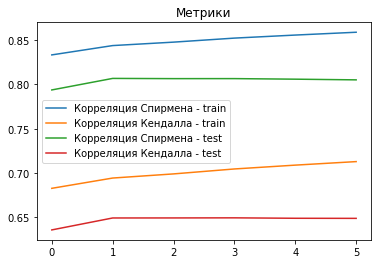

In [106]:
plt.plot(spearman_train, label='Корреляция Спирмена - train')
plt.plot(kendall_train, label='Корреляция Кендалла - train')
plt.plot(spearman_test, label='Корреляция Спирмена - test')
plt.plot(kendall_test, label='Корреляция Кендалла - test')
plt.legend()
plt.title('Метрики')
plt.show()

Видим, что метрики на train растут вместе с итерациями EM алгоритма, при этом метрики на test выросли только после первой итерации EM, эту модель и будем использовать дальше

In [107]:
pickle.dump(best_em_model, open('best_em_model.sav', 'wb'))
pickle.dump(ohe_players, open('players.sav', 'wb'))
pickle.dump(ohe_questions, open('questions.sav', 'wb'))

In [108]:
best_em_model = pickle.load(open('best_em_model.sav', 'rb'))
ohe_players = pickle.load(open('players.sav', 'rb'))
ohe_questions = pickle.load(open('questions.sav', 'rb'))

## 5. А что там с вопросами? 
- Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? 
- Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [109]:
p = best_em_model.coef_[0][:total_players] # "скилл" игрока
q = best_em_model.coef_[0][total_players:] # "сложность" вопроса

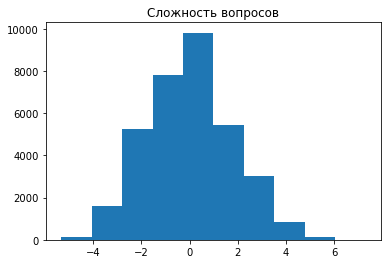

Средняя сложность вопроса: -0.00013746738837973788


In [110]:
plt.hist(q)
plt.title('Сложность вопросов')
plt.show()
print(f'Средняя сложность вопроса: {np.mean(q)}')

Посчитаем для каждого турника среднюю сложность вопросов

In [111]:
tournaments_questions = {}
current_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results_data[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
    tournaments_questions[idx] = q[current_idx:current_idx + (tournament_questions - canceled)]
    current_idx += (tournament_questions - canceled)

100%|██████████| 689/689 [00:00<00:00, 779.04it/s]


In [112]:
average_difficulty = {k: np.mean(v) for k, v in tournaments_questions.items()}

# Отсортируем по сложности

sorted_tournaments = sorted([(k, v) for k, v in average_difficulty.items()],
                            key= lambda x: x[1])

In [113]:
# Турниры с самыми сложными вопросами:

for i, (k, v) in enumerate(sorted_tournaments[:10]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5159-Первенство правого полушария - -2.216
2. 5025-Кубок городов - -1.983
3. 5464-Зимние игры - -1.873
4. 5794-Блаженный Августинер - -1.846
5. 5815-Гусарская лига. III сезон. II этап - -1.846
6. 5083-Ускользающая сова - -1.810
7. 5887-Я.Сова - -1.789
8. 5186-VERSUS: Коробейников vs. Матвеев - -1.675
9. 5671-Чемпионат Минска. Финал - -1.642
10. 5161-Антибинго - -1.639


In [114]:
# Турниры с самыми простыми вопросами:

for i, (k, v) in enumerate(sorted_tournaments[:-10:-1]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5807-Лига Сибири. II тур. - 2.694
2. 5795-Кубок Москвы - 2.591
3. 5013-(а)Синхрон-lite. Лига старта. Эпизод V - 2.511
4. 5797-Третья октава - 2.442
5. 5438-Синхрон Лиги Разума - 2.359
6. 5009-(а)Синхрон-lite. Лига старта. Эпизод III - 2.345
7. 5817-Симбирск-Open - 2.320
8. 5979-ТРИОтлон-4 - 2.252
9. 5457-Студенческий чемпионат Калининградской области - 2.201


Судя по названиям турниров - те, которые попали в самые сложные имеют уровень выше, чем те, которые попали в самые простые

#### Посмотрим на самый сложный и самый простой вопросы

In [115]:
max_d = np.inf
min_d = -np.inf
max_tournament, min_tournament = None, None
max_num, min_num = None, None

for k, v in tournaments_questions.items():
    if np.min(v) <  max_d:
        max_d = np.min(v)
        max_tournament = k
        max_num = np.argmin(v)
        
    if np.max(v) >  min_d:
        min_d = np.max(v)
        min_tournament = k
        min_num = np.argmax(v)

In [116]:
print(f'Самый сложный вопрос имеет сложность {max_d:0.2f} был задан на турнире {max_tournament} {train_tournaments.loc[max_tournament, "name"]} под номером {max_num + 1} из {train_tournaments.loc[max_tournament, "total_questions"]}')
print(f'Самый простой вопрос имеет сложность {min_d:0.2f} был задан на турнире {min_tournament} {train_tournaments.loc[min_tournament, "name"]} под номером {min_num + 1} из {train_tournaments.loc[min_tournament, "total_questions"]}')

Самый сложный вопрос имеет сложность -5.32 был задан на турнире 5025 Кубок городов под номером 43 из 48
Самый простой вопрос имеет сложность 7.29 был задан на турнире 5681 [18+] Болтик в гаечку под номером 35 из 36


Самый сложный вопрос: "В шутке о том, почему некоторым математикам запретили пользоваться общей кухней, упоминаются ТАКИЕ кру́жки. КАКИЕ именно?" <font color='red'>согласен с моделью - вопрос не очевидный)</font>

Самый простой вопрос: не смог найти, так как этого турнира нет на сайте с вопросами

## 6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. 

Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.

Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:

- сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
- можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
- но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
- предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


#### Соберем рейтинги игроков из коэффициентов модели (напомним - в векторе p содержатся коэффициенты модели, которые отвечают за "скилл" игрока)

In [117]:
from scipy import sparse
player_ids1 = ohe_players.inverse_transform(sparse.eye(len(p)))

In [118]:
players_skill = pd.DataFrame(np.concatenate([player_ids1, p.reshape(-1,1)], axis=1),
                             columns = ['id', 'skill'])
players_skill['id'] = players_skill['id'].astype(int)
players_skill = players_skill.set_index('id', drop=True)

# Добавим ФИО

players = pd.DataFrame(players_data.values()).set_index('id', drop=True)
players_skill = players_skill.merge(players, how='left', left_index=True, right_index=True)
players_skill.head()

,skill,name,patronymic,surname
id,,,,
15,0.623846,Олег,Игоревич,Абарников
16,1.851533,Азер,Абасали оглы,Абасалиев
23,0.998571,Андрей,Николаевич,Абащенко
31,0.886040,Ситара,Фахраддин гызы,Абасова
35,1.005969,Нарек,Гагикович,Абгарян


Добавим количество вопросов, на которые отвечали игроки

In [119]:
# вспомним, что мы уже собирали эту информацию
players_total_questions.head()

player_id
15    560.0
16    234.0
23     36.0
31    865.0
35    779.0
Name: total_questions, dtype: float64

In [120]:
players_skill['total_questions'] = players_total_questions
players_skill.head()

,skill,name,patronymic,surname,total_questions
id,,,,,
15,0.623846,Олег,Игоревич,Абарников,560.0
16,1.851533,Азер,Абасали оглы,Абасалиев,234.0
23,0.998571,Андрей,Николаевич,Абащенко,36.0
31,0.886040,Ситара,Фахраддин гызы,Абасова,865.0
35,1.005969,Нарек,Гагикович,Абгарян,779.0


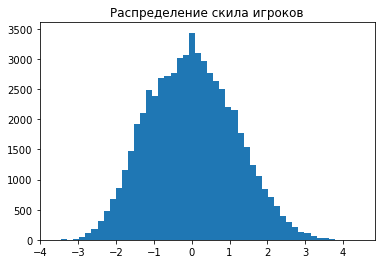

In [121]:
plt.hist(players_skill.skill, bins=50)
plt.title('Распределение скила игроков')
plt.show()

#### Как видим уровень скила распределен похоже на нормальное распределение

#### Посмотрим на top игроков

In [122]:
players_skill.sort_values('skill', ascending=False).head(15)

,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426254,Максим,Михайлович,Руссо,2331.0
4270,4.251737,Александра,Владимировна,Брутер,2881.0
28751,4.232531,Иван,Николаевич,Семушин,3963.0
30152,4.034297,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014479,Михаил,Владимирович,Савченков,3449.0
30270,3.989188,Сергей,Леонидович,Спешков,3962.0
20691,3.861079,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836661,Михаил,Ильич,Левандовский,1502.0
26089,3.821935,Ирина,Сергеевна,Прокофьева,1112.0


Тут на самом деле все получилось лучше, чем я ожидал почти все игроки действительно из топа, всего несколько человек из второй сотни (но это тоже не ноунеймы). Все становится хуже, если посмотреть top 30:

In [123]:
players_skill.sort_values('skill', ascending=False).head(30)

,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426254,Максим,Михайлович,Руссо,2331.0
4270,4.251737,Александра,Владимировна,Брутер,2881.0
28751,4.232531,Иван,Николаевич,Семушин,3963.0
30152,4.034297,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014479,Михаил,Владимирович,Савченков,3449.0
30270,3.989188,Сергей,Леонидович,Спешков,3962.0
20691,3.861079,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836661,Михаил,Ильич,Левандовский,1502.0
26089,3.821935,Ирина,Сергеевна,Прокофьева,1112.0


На 29 месте игрок с 36 вопросами, также в середине есть пара игроков, у которых менее 1000 вопросов - они на самом деле далеко не в первой сотне

Посмотрим на распределение игроков по количеству вопросов в 2019 году

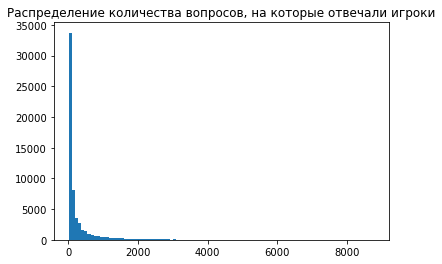

In [124]:
plt.hist(players_skill.total_questions, bins=100)
plt.title('Распределение количества вопросов, на которые отвечали игроки')
plt.show()

 Видим, что большинство игроков отвечали на менее чем 1000 вопросов. Попробуем отсечь тех, кто отвечал менее чем на 1000 вопросов и посмотрим сколько игроков останется.

In [125]:
players_1000 = players_skill[players_skill.total_questions >= 1000].sort_values('skill', ascending=False)
print(f'Всего осталось {len(players_1000)} игроков из {len(players_skill)}')
players_1000.head(30)

Всего осталось 4672 игроков из 59271


,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426254,Максим,Михайлович,Руссо,2331.0
4270,4.251737,Александра,Владимировна,Брутер,2881.0
28751,4.232531,Иван,Николаевич,Семушин,3963.0
30152,4.034297,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014479,Михаил,Владимирович,Савченков,3449.0
30270,3.989188,Сергей,Леонидович,Спешков,3962.0
20691,3.861079,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836661,Михаил,Ильич,Левандовский,1502.0
26089,3.821935,Ирина,Сергеевна,Прокофьева,1112.0


Осталось менее 10%, рейтинг стал лучше, но его вряд ли можно использовать - чтобы попасть в него, игроку придется сыграть сначала 20-30 турниров.

Просто исключить игроков из обучения - не очень хорошая идея, так как в нашей модели заложено то, что каждый игрок вносит свой вклад в результат команды, исключая игроков мы будем делать команду слабее.

В качестве простого улучшения подсчета рейтинга я предлагаю умножать рейтинг игрока на сигмоиду для тех игроков, которые отвечали менее чем на 1000 вопросов. Это позволит игрокам сразу попадать в нижнюю часть рейтинга и подниматься вверх по мере получения опыта.

In [126]:
def sigmoid(x):
    x = 1.0 / (1.0 + np.exp(-1.0 * x))
    return x

def rating_adjustment(x):
    t = x / 100 - 5
    return sigmoid(t)

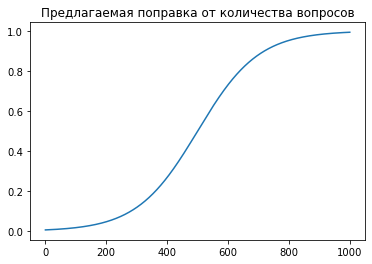

In [127]:
x = np.linspace(-0, 1000, 1000)
plt.plot(x, rating_adjustment(x))
plt.title('Предлагаемая поправка от количества вопросов')
plt.show()

In [128]:
def adjust_rating(x):
    if x.total_questions > 1000:
        return x.skill_positive
    return x.skill_positive * rating_adjustment(x.total_questions)

In [129]:
min_skill = players_skill.skill.min()
players_skill['skill_positive'] = players_skill.skill - min_skill
players_skill['adjusted_skill'] = players_skill.apply(adjust_rating, axis=1) + min_skill

Посмотрим на новый топ

In [130]:
players_adjusted = players_skill.sort_values('adjusted_skill', ascending=False)
players_adjusted.head(30)

,skill,name,patronymic,surname,total_questions,skill_positive,adjusted_skill
id,,,,,,,
27403,4.426254,Максим,Михайлович,Руссо,2331.0,8.038912,4.426254
4270,4.251737,Александра,Владимировна,Брутер,2881.0,7.864395,4.251737
28751,4.232531,Иван,Николаевич,Семушин,3963.0,7.845189,4.232531
30152,4.034297,Артём,Сергеевич,Сорожкин,5083.0,7.646956,4.034297
27822,4.014479,Михаил,Владимирович,Савченков,3449.0,7.627137,4.014479
30270,3.989188,Сергей,Леонидович,Спешков,3962.0,7.601846,3.989188
20691,3.861079,Станислав,Григорьевич,Мереминский,1656.0,7.473737,3.861079
18036,3.836661,Михаил,Ильич,Левандовский,1502.0,7.449320,3.836661
26089,3.821935,Ирина,Сергеевна,Прокофьева,1112.0,7.434594,3.821935


Рейтинг стал более стабильным, попробуем теперь применить его для предсказания результатов турниров

In [131]:
# Загружаем лучшую модель
adjusted_model = pickle.load(open('best_em_model.sav', 'rb'))
# Меняем в ней коэффициенты, отвечающие за скилл
ordered_players = ohe_players.inverse_transform(sparse.eye(len(p)))
adjusted_model.coef_[:, :len(ordered_players)] = players_adjusted.loc[ordered_players.reshape(-1)].adjusted_skill.values.reshape(1,-1)

In [132]:
spearman_corr_adjusted, kendall_corr_adjusted = calculate_metrics(adjusted_model)

100%|██████████| 416/416 [01:20<00:00,  5.15it/s]


In [133]:
print('Adjusted model')
print(f'Корреляция Спирмена - test: {spearman_corr_adjusted:0.4f}')
print(f'Корреляция Кендалла - test: {kendall_corr_adjusted:0.4f}')

Adjusted model
Корреляция Спирмена - test: 0.7542
Корреляция Кендалла - test: 0.5965


#### Как видим модель потеряла в качестве предсказания результатов турнира после такого вмешательства.

## Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:
- если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
- одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
- предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.


<font color='blue'>К сожалению, на реализацию у меня не хватает времени, поэтому опишу направление, в котором я бы начал двигаться: </font>

- Аналогично тому, как я исправлял рейтинги игроков попробовать применить сигмоиду или другое сглаживание (например экспоненциальное) для того, чтобы турниры из прошлого не так сильно влияли на текущий рейтинг. Как вариант - строить рейтинги с окном в 1 год за каждый месяц и потом сглаживать этот ряд экспонентой.